In [71]:
# téléchargement

from pymatgen.ext.matproj import MPRester
import pymatgen.electronic_structure.core as elstruct
from pymatgen.electronic_structure import plotter
from matplotlib import pyplot as plt
import numpy as np

cle_materiau = "mp-20072"
cle_utilisateur = "om6hvHlirPcyuxXF"

with MPRester(cle_utilisateur) as m:
    band = m.get_bandstructure_by_material_id(cle_materiau)
    plot = plotter.BSPlotter(band)

In [72]:
# on récupère la bande interdite et on imprime ses attributs
band_gap = band.get_band_gap()
print('La bande interdite est directe ?     : '+str(band_gap['direct']))
print('L\'énergie de la bande interdite est  : '+str(round(band_gap['energy'],4))+' [eV]')
print('transition de la bande interdite     : '+band_gap['transition']+'\n')

La bande interdite est directe ?     : False
L'énergie de la bande interdite est  : 2.5162 [eV]
transition de la bande interdite     : Z-L



In [73]:
# on prépare les données pour la suite des calculs

# on recupere et prépare les donnees pour les premieres et dernieres bandes de conduction et valence
cv_bands = [band.get_cbm(), band.get_vbm()]
names = ['première bande de conduction', 'dernière bande de valence']
names_to_get_the_data = ['cbm', 'vbm']
colors = ['r','g']

list = zip(cv_bands, names, names_to_get_the_data, colors)

# petit helper pour calculer la pente entre 2 points
pente = lambda x,y : abs((y[-1]-y[0])/(x[-1]-x[0]))

# petit helper pour retourner x[0],y[0],x[-1]-x[0],y[-1]-y[0]
coord = lambda x,y,index : [ x[0], y[index][0], x[-1]-x[0], y[index][-1]-y[index][0]]

# on cree la clé utile à recuperer les bandes de frequence
cle = elstruct.Spin(1)

# on récupère les axes x et y selon lesquels sont plottées les bandes et d'autres données utiles au plot 
donnees_plot = plot.bs_plot_data()
x = donnees_plot.get('distances')
y = [ yi.get('1') for yi in donnees_plot.get('energy')]
ticks = donnees_plot.get('ticks').get('distance')
nb_ticks = len(x)

In [74]:
# petite fonction utilitaire avec exemple

def get_indexes(a, number=1,maxi=True):
    """
    donne dans un tableau les indices des 'numbers' premiers maximums du tableau 'a'
    par défaut, la fonction renvoie le maximum du tableau (numbers = 1)
    
    Si max est mis à 'False', la fonction ne cherche plus les indices des maximus
    mais ceux des minimums
    """
    index = [-1]*number
    if maxi:
        init_value = min(a)
        condition = lambda a,b : a > b
    else:
        init_value = max(a)
        condition = lambda a,b : a < b
    
    for i in range(number):
        max_min = init_value
        index_i = -1
        for j in range(len(a)):
            if condition(a[j],max_min)  and j not in index:
                max_min = a[j]
                index_i = j
        index[i] = index_i
    
    return index
    

# exemple 

a = [0,500,8,-5,12]
print('si a = '+str(a)+' et numbers = 2,')
print('le résultat est : '+str(get_indexes(a,2)))
print('ce qui donne bien les indices des 2 plus grandes valeurs du tableau')
print('\nsi on fait l\'opération avec max à False, on a : '+str(get_indexes(a,2,False)))
print('ce qui donne bien les indices des 2 plus petites valeurs du tableau')

si a = [0, 500, 8, -5, 12] et numbers = 2,
le résultat est : [1, 4]
ce qui donne bien les indices des 2 plus grandes valeurs du tableau

si on fait l'opération avec max à False, on a : [3, 0]
ce qui donne bien les indices des 2 plus petites valeurs du tableau



bande(s) correspondant à la première bande de conduction : 
20 
énergie  : 6.5501 eV

bande(s) correspondant à la dernière bande de valence : 
18 19 
énergie  : 4.0339 eV


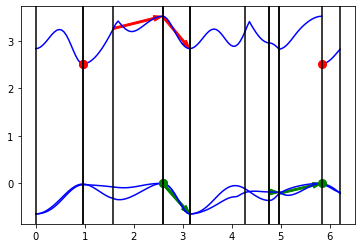

In [75]:
# on imprime les données pour chaque bande avec également un joli plot

for info_bm,name,cvbm,col in list:
    
    index_bandes = info_bm['band_index'][cle]
    len_index = len(index_bandes)
    print('\nbande(s) correspondant à la '+name+' : ')
    
    # il faut maintenant chercher les max et min de dispersion pour chaque bande : 
    # les pentes max et min pour les bandes concernées
    pente_bande = np.zeros((len_index,nb_ticks))
    k = 0
    for index in index_bandes:
        print(index, end=' ')
        for i in range(nb_ticks):
            yi = y[i][index]
            xi = x[i]
            pente_bande[k][i] = pente(xi, yi)
            plt.plot(xi, yi,'b')
        index_max = get_indexes(pente_bande[k])[0]
        index_min = get_indexes(pente_bande[k], maxi = False)[0]
        
        # on récupère les coordonnées de début et fin de la zone dans laquelle se trouvent le max
        # et le min de dispersion
        for index_m in [index_min, index_max]:
            points = coord(x[index_m], y[index_m], index)
            plt.arrow(points[0],points[1],points[2],points[3],color=col,width=.04,length_includes_head=True)
        k+=1
    
    print('\nénergie  : '+str(info_bm['energy'])+' eV')
    
    # on imprime les points marquants les min ou max de la bande en question
    for xi,yi in donnees_plot.get(cvbm):
        plt.plot(xi,yi,'o'+col,markersize=8)
        

for xi in ticks:
    plt.axvline(xi,0,color="black")        
plt.show()